### 請解壓縮data.rar，取得本程式之數據

In [1]:
from google.colab import drive
%tensorflow_version 1.x
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from keras.layers import Conv2D , UpSampling2D , MaxPooling2D , concatenate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
import cv2
import os
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
path = os.path.join(os.getcwd() , 'gdrive' , 'My Drive' , 'unet_ISIC-2017')
os.chdir(path)

TensorFlow 1.x selected.


Using TensorFlow backend.


Mounted at /content/gdrive


In [2]:
images = np.load('images.npy')
masks = np.load('masks.npy')
masks = np.expand_dims(masks , axis = -1)

(x_train , x_test , y_train , y_test) =\
train_test_split(images ,
                 masks,
                 test_size = 0.1 ,
                 random_state = 42)

del images , masks

In [3]:
def metrics(y_true , y_pred):
    y_true = np.reshape(y_true , [-1])
    y_pred = np.reshape(y_pred , [-1])
    y_true = np.where(y_true > 0.5 , 1 , 0)
    y_pred = np.where(y_pred > 0.5 , 1 , 0)
    cm = confusion_matrix(y_true , y_pred)
    accuracy = (cm[0 , 0] + cm[1 , 1]) / np.sum(cm)
    recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
    precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])
    f1_score = 2 * recall * precision / (recall + precision)
    return accuracy , recall , precision , f1_score


def batch_norm_layer(inputs , on_train , convolution):
    # the dimension you wanna normalize, here [0] for batch
    # for image, you wanna do [0 , 1 , 2] for [batch , height , width] but not channel
    if convolution:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0 , 1 , 2] , name = 'mean_var')
    else:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0] , name = 'mean_var')
    
    ema = tf.train.ExponentialMovingAverage(decay = 0.75)
    ema_apply_op = ema.apply([fc_mean , fc_var])
    mean = tf.cond(on_train , lambda : fc_mean , lambda : ema.average(fc_mean))
    var = tf.cond(on_train , lambda : fc_var , lambda : ema.average(fc_var))
    
    scale = tf.Variable(tf.ones([1 , inputs.shape[-1].value]) , name = 'scale') 
    shift = tf.Variable(tf.zeros([1 , inputs.shape[-1].value]) , name = 'shift')
    temp = (inputs - mean) / tf.sqrt(var + 0.001)
    outputs = tf.multiply(temp , scale) + shift
  
    return outputs , ema_apply_op


def conv_block(inputs , n_filter , kernel_size = 3 , activation = tf.nn.relu ,
               padding = 'same' , kernel_initializer = 'glorot_uniform' , batch_norm = True):
    conv = Conv2D(n_filter , kernel_size , activation = None , padding = padding ,
                   kernel_initializer = kernel_initializer)(inputs)

    if batch_norm: conv , ema1 = batch_norm_layer(conv , on_train , True)

    conv = activation(conv)
    conv = Conv2D(n_filter , kernel_size , activation = None , padding = padding ,
                   kernel_initializer = kernel_initializer)(conv)

    if batch_norm: conv , ema2 = batch_norm_layer(conv , on_train , True)

    conv = activation(conv)
    return conv , [ema1 , ema2]


def up_block(inputs , n_filter , kernel_size = 3 , activation =  tf.nn.relu ,
             padding = 'same' , kernel_initializer = 'glorot_uniform' , batch_norm = True):
    up_ = UpSampling2D(size = (2 , 2))(inputs)
    up = Conv2D(n_filter , kernel_size , activation = None , padding = padding ,
                kernel_initializer = kernel_initializer)(up_)

    if batch_norm: up , ema = batch_norm_layer(up , on_train , True)

    up = activation(up)
    return up , ema


def batch_generator(X , y , batch_size):
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i = 0
    while True:
        if i + batch_size <= size:
            yield X_copy[i : i + batch_size] , y_copy[i : i + batch_size]
            i += batch_size
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]

In [4]:
ema = []
inputs = tf.placeholder(tf.float32 , [None , 256 , 256 , 3] , name = 'inputs')
y_true = tf.placeholder(tf.float32 , [None , 256 , 256 , 1] , name = 'y_true')
keep_prob = tf.placeholder(tf.float32 , name = 'keep_prob')
on_train = tf.placeholder(tf.bool , name = 'on_train')

In [5]:
with tf.variable_scope('Encoder_Stage'):
    with tf.variable_scope('Conv1'):
        conv1 , ema1 = conv_block(inputs , 64)
        pool1 = MaxPooling2D(pool_size = (2 , 2))(conv1)
        ema.extend(ema1)

    with tf.variable_scope('Conv2'):
        conv2 , ema2 = conv_block(pool1 , 128)
        pool2 = MaxPooling2D(pool_size = (2 , 2))(conv2)
        ema.extend(ema2)
    
    with tf.variable_scope('Conv3'):
        conv3 , ema3 = conv_block(pool2 , 256)
        pool3 = MaxPooling2D(pool_size = (2 , 2))(conv3)
        ema.extend(ema3)

    with tf.variable_scope('Conv4'):
        conv4 , ema4 = conv_block(pool3 , 512)
        pool4 = MaxPooling2D(pool_size = (2 , 2))(conv4)
        ema.extend(ema4)


with tf.variable_scope('Middle_Stage'):
    conv5 , ema5 = conv_block(pool4 , 1024)
    drop5 = tf.nn.dropout(conv5 , keep_prob)
    ema.extend(ema5)


with tf.variable_scope('Decoder_Stage'):
    with tf.variable_scope('Conv5'):
        up6 , ema6_1 = up_block(drop5 , 512)
        concat6 = concatenate([conv4 , up6] , axis = -1)
        conv6 , ema6_2 = conv_block(concat6 , 512)
        ema.extend([ema6_1])
        ema.extend(ema6_2)

    with tf.variable_scope('Conv7'):
        up7 , ema7_1 = up_block(conv6 , 256)
        concat7 = concatenate([conv3 , up7] , axis = -1)
        conv7 , ema7_2 = conv_block(concat7 , 256)
        ema.extend([ema7_1])
        ema.extend(ema7_2)

    with tf.variable_scope('Conv8'):
        up8 , ema8_1 = up_block(conv7 , 128)
        concat8 = concatenate([conv2 , up8] , axis = -1)
        conv8 , ema8_2 = conv_block(concat8 , 128)
        ema.extend([ema8_1])
        ema.extend(ema8_2)

    with tf.variable_scope('Conv9'):
        up9 , ema9_1 = up_block(conv8 , 64)
        concat9 = concatenate([conv1 , up9] , axis = -1)
        conv9 , ema9_2 = conv_block(concat9 , 64)
        ema.extend([ema9_1])
        ema.extend(ema9_2)


with tf.variable_scope('Output_Stage'):
    y_pred = Conv2D(1 , 1 , activation = 'sigmoid' , padding = 'same' ,
                    kernel_initializer = 'glorot_uniform')(conv9)


with tf.variable_scope('Optimizer'):
    update_ema = tf.group(ema)
    cross_entropy = y_true * tf.log(tf.clip_by_value(y_pred , 1e-8 , tf.reduce_max(y_pred))) +\
                    (1 - y_true) * tf.log(tf.clip_by_value(1 - y_pred , 1e-8 , tf.reduce_max(1 - y_pred)))
    loss = -tf.reduce_mean(cross_entropy)
    train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.variable_scope('IOU'):
    smooth = 1e-8
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    sum_ = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
    iou = (intersection + smooth) / (sum_ - intersection + smooth)    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
image_grnerator = ImageDataGenerator(rotation_range = 0.1,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     shear_range = 0.02 ,
                                     zoom_range = 0.02,
                                     horizontal_flip = True ,
                                     fill_mode = 'nearest')

mask_grnerator = ImageDataGenerator(rotation_range = 0.1,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.02 ,
                                    zoom_range = 0.02,
                                    horizontal_flip = True ,
                                    fill_mode = 'nearest')

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 8
train_batch_generator = batch_generator(x_train , y_train , batch_size)
epochs = 100
num_batch = math.ceil(len(x_train) / batch_size)
for epoch_i in range(0 , epochs):
    train_loss_mean = 0
    for batch_i in range(0 , num_batch):
        x_train_bathch , y_train_bathch = next(train_batch_generator)
        x_train_bathch_aug = image_grnerator.flow(x_train_bathch , np.arange(8) , shuffle = False , batch_size = batch_size , seed = 1)
        y_train_bathch_aug = mask_grnerator.flow(y_train_bathch , np.arange(8) , shuffle = False , batch_size = batch_size , seed = 1)
        x_train_bathch_aug = x_train_bathch_aug[0][0]
        y_train_bathch_aug = y_train_bathch_aug[0][0]

        _ , _ , train_loss = sess.run([train_op , update_ema , loss] ,
                                      feed_dict = {inputs : x_train_bathch_aug ,
                                                   y_true : y_train_bathch_aug / 255. ,
                                                   keep_prob : 0.8 ,
                                                   on_train : True})
        train_loss_mean += train_loss

    print('=' * 30)
    print('epoch : {}'.format(epoch_i))
    print('train_loss_mean : {:.3f}'.format(train_loss_mean / num_batch))

    test_loss_sum = 0
    test_iou_sum = 0
    y_test_pred = np.zeros([len(x_test) , 256 , 256 , 1])
    for test_batch_i in range(0 , 10):
        test_loss , test_iou , y_test_pred_ =\
        sess.run([loss , iou , y_pred] ,
                feed_dict = {inputs : x_test[10*test_batch_i : 10*(test_batch_i+1)]  ,
                             y_true : y_test[10*test_batch_i : 10*(test_batch_i+1)]  / 255. ,
                             keep_prob : 1 ,
                             on_train : False})
        test_loss_sum += test_loss
        test_iou_sum += test_iou
        y_test_pred[10*test_batch_i : 10*(test_batch_i+1)]  = y_test_pred_

    accuracy_test , recall_test , precision_test , f1_score_test = metrics(y_test , y_test_pred)
    print('*' * 30)
    print('test_loss : {:.3f}'.format(test_loss_sum / 10))
    print('test_iou : {:.3f}'.format(test_iou_sum / 10))
    print('test_accuracy : {:.2%}'.format(accuracy_test))
    print('test_recall : {:.3f}'.format(recall_test))
    print('test_precision : {:.3f}'.format(precision_test))
    print('test_f1_score : {:.3f}'.format(f1_score_test))
    print('*' * 30)

epoch : 0
train_loss_mean : 0.332
******************************
test_loss : 0.238
test_iou : 0.763
test_accuracy : 92.00%
test_recall : 0.830
test_precision : 0.863
test_f1_score : 0.846
******************************
epoch : 1
train_loss_mean : 0.236
******************************
test_loss : 0.174
test_iou : 0.834
test_accuracy : 94.24%
test_recall : 0.862
test_precision : 0.916
test_f1_score : 0.888
******************************
epoch : 2
train_loss_mean : 0.205
******************************
test_loss : 0.161
test_iou : 0.839
test_accuracy : 94.12%
test_recall : 0.819
test_precision : 0.953
test_f1_score : 0.881
******************************
epoch : 3
train_loss_mean : 0.184
******************************
test_loss : 0.161
test_iou : 0.828
test_accuracy : 93.87%
test_recall : 0.808
test_precision : 0.954
test_f1_score : 0.875
******************************
epoch : 4
train_loss_mean : 0.171
******************************
test_loss : 0.135
test_iou : 0.865
test_accuracy : 95.20%
t

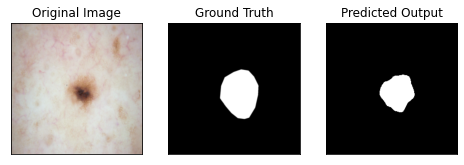

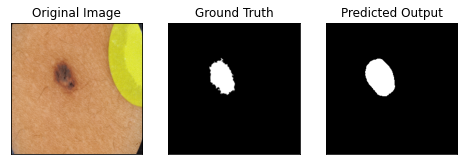

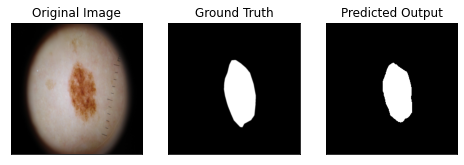

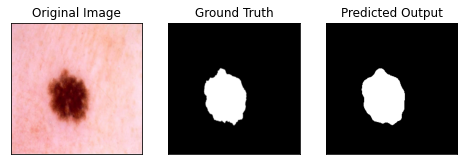

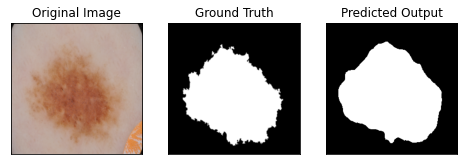

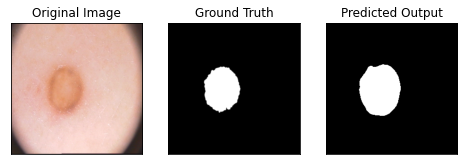

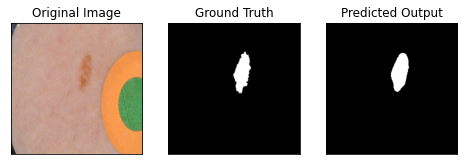

In [8]:
img_idx_list = [15 , 20 , 25 , 35 , 50 , 75 , 85]
for img_idx in img_idx_list:
    img_pred =  sess.run(y_pred , feed_dict = {inputs : np.expand_dims(x_test[img_idx] , axis = 0)  ,
                                keep_prob : 1 ,
                                on_train : False})

    fig , ax = plt.subplots(1 , 3 , figsize = (8 , 8))

    ax[0].imshow(x_test[img_idx] / 255.)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original Image')

    ax[1].imshow(y_test[img_idx , : , : , 0] , plt.cm.binary_r)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Ground Truth')

    img_pred = np.round(img_pred)
    ax[2].imshow(img_pred[0 , : , : , 0] , plt.cm.binary_r)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title('Predicted Output')

In [9]:
saver = tf.train.Saver()
saver.save(sess , 'unet/unet_bce_model')
print('Model Trained and Saved')

Model Trained and Saved
